# Renovation Graph Node Testing

This notebook allows you to test individual nodes of the renovation estimation pipeline.

## Modes

- **Fixture mode** (`MODE = "fixture"`): Uses offline fixture data, no API calls
- **Live mode** (`MODE = "live"`): Makes real API calls to Apify/OpenAI

## Pipeline Steps

1. **Scrape**: Fetch property data from Idealista via Apify
2. **Classify**: Classify each image to identify room types
3. **Group**: Group images by room (pure logic, always runs live)
4. **Estimate**: Analyze each room and estimate renovation costs
5. **Summarize**: Generate final report with totals

### Using the backend uv venv

1. **Install the notebook extra** (from `backend/`): `uv sync --extra notebook`

2. **Select the venv as the kernel** in Cursor/VS Code:
   - Click the kernel selector (top-right of the notebook).
   - Choose **"Jupyter Kernel..."** → **"Python housing_agent"** (this is the registered backend .venv).
   - If that doesn’t appear: **"Python Environments..."** → **"Enter path to Python interpreter"** →  
     `backend/.venv/bin/python3` (or the full path to your `backend/.venv/bin/python3`).

## 1. Setup

In [1]:
# Add parent directory to path so we can import app modules
import sys
from pathlib import Path

backend_dir = Path.cwd().parent
if str(backend_dir) not in sys.path:
    sys.path.insert(0, str(backend_dir))

# Load environment variables
from dotenv import load_dotenv
load_dotenv(backend_dir / ".env")

# Imports
import json
from pprint import pprint
from app.config import Settings
from app.graphs.main_graph import (
    scrape_node,
    classify_node,
    group_node,
    estimate_node,
    summarize_node,
    build_renovation_graph,
)
from app.graphs.state import create_initial_state
from fixtures import get_state_after, SAMPLE_URL

print("✅ Setup complete")

/Users/armindomatias/code/armindomatias/personal/housing_agent/backend/.venv/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


✅ Setup complete


## 2. Mode Selection

In [2]:
# Choose mode: "fixture" or "live"
MODE = "live"  # Change to "live" for real API calls

# Initialize settings
settings = Settings()

# For live mode, optionally override the sample URL
#IDEALISTA_URL = SAMPLE_URL  # Change this for live mode
#IDEALISTA_URL = "https://www.idealista.pt/imovel/34810407/"  # Change this for live mode
IDEALISTA_URL = "https://www.idealista.pt/imovel/34675004/"

print(f"Mode: {MODE}")
print(f"URL: {IDEALISTA_URL}")
if MODE == "live":
    print(f"OpenAI Model (estimation): {settings.openai_vision_model}")
    print(f"OpenAI Model (classification): {settings.openai_classification_model}")

Mode: live
URL: https://www.idealista.pt/imovel/34675004/
OpenAI Model (estimation): gpt-4o
OpenAI Model (classification): gpt-4o-mini


## 3. Load Fixtures

In [3]:
# Show available fixture stages
stages = ["initial", "scrape", "classify", "group", "estimate", "summarize"]
print("Available fixture stages:")
for stage in stages:
    state = get_state_after(stage)
    print(f"  - {stage}: current_step='{state.get('current_step', 'N/A')}'")

Available fixture stages:
  - initial: current_step='starting'
  - scrape: current_step='scraped'
  - classify: current_step='classified'
  - group: current_step='grouped'
  - estimate: current_step='estimated'
  - summarize: current_step='completed'


## 4. Helper Functions

In [4]:
def show_state(state, keys=None):
    """Pretty-print specific keys from state."""
    if keys is None:
        keys = ["current_step", "error"]
    
    subset = {k: state.get(k) for k in keys if k in state}
    pprint(subset)


def show_events(state):
    """Show stream events from state."""
    events = state.get("stream_events", [])
    print(f"\nStream Events ({len(events)}):")
    for i, event in enumerate(events, 1):
        msg = event.message if hasattr(event, 'message') else event.get('message', '')
        event_type = event.type if hasattr(event, 'type') else event.get('type', '')
        print(f"  {i}. [{event_type}] {msg}")


def show_property_data(state):
    """Show scraped property data."""
    prop = state.get("property_data")
    if prop:
        print(f"\nProperty Data:")
        print(f"  Title: {prop.title if hasattr(prop, 'title') else prop.get('title', 'N/A')}")
        print(f"  Price: {prop.price if hasattr(prop, 'price') else prop.get('price', 0):,.0f}€")
        print(f"  Area: {prop.area_m2 if hasattr(prop, 'area_m2') else prop.get('area_m2', 0)} m²")
        num_images = len(prop.image_urls) if hasattr(prop, 'image_urls') else len(prop.get('image_urls', []))
        print(f"  Images: {num_images}")


def show_classifications(state):
    """Show classification results."""
    classifications = state.get("classifications", [])
    print(f"\nClassifications ({len(classifications)}):")
    for i, c in enumerate(classifications, 1):
        room_type = c.room_type.value if hasattr(c, 'room_type') else c.get('room_type', 'N/A')
        room_num = c.room_number if hasattr(c, 'room_number') else c.get('room_number', 0)
        conf = c.confidence if hasattr(c, 'confidence') else c.get('confidence', 0)
        print(f"  {i}. {room_type} #{room_num} (confidence: {conf:.2f})")


def show_grouped_images(state):
    """Show grouped images by room."""
    grouped = state.get("grouped_images", {})
    print(f"\nGrouped Images ({len(grouped)} rooms):")
    for room_key, images in grouped.items():
        print(f"  {room_key}: {len(images)} image(s)")


def show_room_analyses(state):
    """Show room analysis results."""
    analyses = state.get("room_analyses", [])
    print(f"\nRoom Analyses ({len(analyses)}):")
    for analysis in analyses:
        label = analysis.room_label if hasattr(analysis, 'room_label') else analysis.get('room_label', 'N/A')
        condition = analysis.condition.value if hasattr(analysis, 'condition') else analysis.get('condition', 'N/A')
        cost_min = analysis.cost_min if hasattr(analysis, 'cost_min') else analysis.get('cost_min', 0)
        cost_max = analysis.cost_max if hasattr(analysis, 'cost_max') else analysis.get('cost_max', 0)
        num_items = len(analysis.renovation_items) if hasattr(analysis, 'renovation_items') else len(analysis.get('renovation_items', []))
        print(f"  {label}: {condition} | {cost_min:,.0f}€ - {cost_max:,.0f}€ | {num_items} items")


def show_estimate(state):
    """Show final estimate."""
    estimate = state.get("estimate")
    if estimate:
        total_min = estimate.total_cost_min if hasattr(estimate, 'total_cost_min') else estimate.get('total_cost_min', 0)
        total_max = estimate.total_cost_max if hasattr(estimate, 'total_cost_max') else estimate.get('total_cost_max', 0)
        summary = estimate.summary if hasattr(estimate, 'summary') else estimate.get('summary', '')
        print(f"\nFinal Estimate:")
        print(f"  Total: {total_min:,.0f}€ - {total_max:,.0f}€")
        print(f"  Summary: {summary[:150]}..." if len(summary) > 150 else f"  Summary: {summary}")

print("✅ Helper functions loaded")

✅ Helper functions loaded


## 5. Node 1: Scrape

Fetch property data from Idealista via Apify.

In [5]:
if MODE == "fixture":
    # Load fixture state
    state_after_scrape = get_state_after("scrape")
    print("✅ Loaded fixture state after scrape")
else:
    # Run live scrape
    initial_state = create_initial_state(IDEALISTA_URL, user_id="notebook_test")
    state_after_scrape = await scrape_node(initial_state, settings=settings)
    print("✅ Scrape completed")

show_state(state_after_scrape, ["current_step", "error"])
show_property_data(state_after_scrape)
show_events(state_after_scrape)

✅ Scrape completed
{'current_step': 'scraped', 'error': None}

Property Data:
  Title: Quinta da Aduela no number
  Price: 285,000€
  Area: 56.0 m²
  Images: 21

Stream Events (2):
  1. [status] A obter dados do Idealista...
  2. [status] Encontradas 21 fotografias


In [6]:
for i in state_after_scrape["property_data"]:
    print(i)

('url', 'https://www.idealista.pt/imovel/34675004/')
('title', 'Quinta da Aduela no number')
('price', 285000.0)
('area_m2', 56.0)
('usable_area_m2', 55.0)
('num_rooms', 2)
('num_bathrooms', 1)
('floor', '2')
('location', 'Lisboa, Lisboa')
('description', 'Excelente apartamento T2 no coração do Bairro Madre de Deus, no Beato — uma zona em crescimento e cada vez mais procurada tanto para habitação como para investimento.\nCom excelentes condições de luz natural, localização privilegiada e um raro sótão com a mesma área do apartamento, este imóvel oferece um potencial adicional extraordinário.\n\nCaracterísticas Principais:\n\n-55 m² bem distribuídos e com excelente exposição solar;\n-Sótão com a área total do apartamento, ideal para arrumos ou futura valorização;\n-Intervenções realizadas há cerca de 2 anos: pintura, pavimento novo, janelas e loiças da casa-de-banho renovadas;\n-2 quartos de boas dimensões com ótima luz natural;\n-Sala de estar e jantar convidativa;\n-Casa-de-banho com 

## 6. Node 2: Classify

Classify each image to identify room types using GPT-4o-mini.

In [7]:
if MODE == "fixture":
    # Load fixture state
    state_after_classify = get_state_after("classify")
    print("✅ Loaded fixture state after classify")
else:
    # Run live classify
    state_after_classify = await classify_node(state_after_scrape, settings=settings)
    print("✅ Classify completed")

show_state(state_after_classify, ["current_step", "error"])
show_classifications(state_after_classify)
show_events(state_after_classify)

✅ Classify completed
{'current_step': 'classified', 'error': None}

Classifications (21):
  1. sala #1 (confidence: 0.85)
  2. quarto #1 (confidence: 0.95)
  3. sala #1 (confidence: 0.85)
  4. quarto #1 (confidence: 0.95)
  5. casa_de_banho #1 (confidence: 0.95)
  6. corredor #1 (confidence: 0.95)
  7. cozinha #1 (confidence: 0.95)
  8. quarto #1 (confidence: 0.95)
  9. sala #1 (confidence: 0.85)
  10. exterior #1 (confidence: 0.95)
  11. cozinha #1 (confidence: 0.95)
  12. quarto #1 (confidence: 0.85)
  13. sala #1 (confidence: 0.95)
  14. exterior #1 (confidence: 0.95)
  15. casa_de_banho #1 (confidence: 0.85)
  16. exterior #1 (confidence: 0.80)
  17. cozinha #1 (confidence: 0.95)
  18. quarto #1 (confidence: 0.95)
  19. cozinha #1 (confidence: 0.95)
  20. corredor #1 (confidence: 0.85)
  21. sala #1 (confidence: 0.85)

Stream Events (25):
  1. [status] A obter dados do Idealista...
  2. [status] Encontradas 21 fotografias
  3. [status] A classificar 21 fotografias...
  4. [progress

## 7. Node 3: Group

Group images by room (pure logic, no API calls).

In [8]:
# Always run live (pure logic, no API calls)
if MODE == "fixture":
    state_after_group = get_state_after("group")
    print("✅ Loaded fixture state after group")
else:
    state_after_group = await group_node(state_after_classify, settings=settings)
    print("✅ Group completed")

show_state(state_after_group, ["current_step", "error"])
show_grouped_images(state_after_group)
show_events(state_after_group)

✅ Group completed
{'current_step': 'grouped', 'error': None}

Grouped Images (5 rooms):
  sala_1: 5 image(s)
  quarto_1: 5 image(s)
  casa_de_banho_1: 2 image(s)
  corredor_1: 2 image(s)
  cozinha_1: 4 image(s)

Stream Events (27):
  1. [status] A obter dados do Idealista...
  2. [status] Encontradas 21 fotografias
  3. [status] A classificar 21 fotografias...
  4. [progress] A classificar foto 1/21: Sala detectada
  5. [progress] A classificar foto 2/21: Quarto 1 detectada
  6. [progress] A classificar foto 3/21: Sala detectada
  7. [progress] A classificar foto 4/21: Quarto 1 detectada
  8. [progress] A classificar foto 5/21: Casa de Banho 1 detectada
  9. [progress] A classificar foto 6/21: Corredor detectada
  10. [progress] A classificar foto 7/21: Cozinha detectada
  11. [progress] A classificar foto 8/21: Quarto 1 detectada
  12. [progress] A classificar foto 9/21: Sala detectada
  13. [progress] A classificar foto 10/21: Exterior detectada
  14. [progress] A classificar foto 11

In [9]:
state_after_group["grouped_images"]

{'sala_1': [{'image_url': 'https://img4.idealista.pt/blur/WEB_DETAIL-XL-L/0/id.pro.pt.image.master/36/bd/16/303162310.webp',
   'room_type': 'sala',
   'room_number': 1,
   'confidence': 0.85},
  {'image_url': 'https://img4.idealista.pt/blur/WEB_DETAIL-XL-L/0/id.pro.pt.image.master/cf/4f/40/303162319.webp',
   'room_type': 'sala',
   'room_number': 1,
   'confidence': 0.85},
  {'image_url': 'https://img4.idealista.pt/blur/WEB_DETAIL-XL-L/0/id.pro.pt.image.master/2d/d9/71/303162300.webp',
   'room_type': 'sala',
   'room_number': 1,
   'confidence': 0.85},
  {'image_url': 'https://img4.idealista.pt/blur/WEB_DETAIL-XL-L/0/id.pro.pt.image.master/39/b3/7a/303162318.webp',
   'room_type': 'sala',
   'room_number': 1,
   'confidence': 0.95},
  {'image_url': 'https://img4.idealista.pt/blur/WEB_DETAIL-XL-L/0/id.pro.pt.image.master/ee/f9/2b/303162309.webp',
   'room_type': 'sala',
   'room_number': 1,
   'confidence': 0.85}],
 'quarto_1': [{'image_url': 'https://img4.idealista.pt/blur/WEB_DETAI

## 8. Node 4: Estimate

Analyze each room and estimate renovation costs using GPT-4o Vision.

In [10]:
if MODE == "fixture":
    # Load fixture state
    state_after_estimate = get_state_after("estimate")
    print("✅ Loaded fixture state after estimate")
else:
    # Run live estimate
    state_after_estimate = await estimate_node(state_after_group, settings=settings)
    print("✅ Estimate completed")

show_state(state_after_estimate, ["current_step", "error"])
show_room_analyses(state_after_estimate)
show_events(state_after_estimate)

✅ Estimate completed
{'current_step': 'estimated', 'error': None}

Room Analyses (5):
  Sala: razoavel | 480€ - 900€ | 1 items
  Quarto 1: razoavel | 1,100€ - 2,250€ | 3 items
  Casa de Banho 1: razoavel | 2,500€ - 6,600€ | 5 items
  Corredor: razoavel | 350€ - 700€ | 2 items
  Cozinha: razoavel | 6,800€ - 13,100€ | 5 items

Stream Events (39):
  1. [status] A obter dados do Idealista...
  2. [status] Encontradas 21 fotografias
  3. [status] A classificar 21 fotografias...
  4. [progress] A classificar foto 1/21: Sala detectada
  5. [progress] A classificar foto 2/21: Quarto 1 detectada
  6. [progress] A classificar foto 3/21: Sala detectada
  7. [progress] A classificar foto 4/21: Quarto 1 detectada
  8. [progress] A classificar foto 5/21: Casa de Banho 1 detectada
  9. [progress] A classificar foto 6/21: Corredor detectada
  10. [progress] A classificar foto 7/21: Cozinha detectada
  11. [progress] A classificar foto 8/21: Quarto 1 detectada
  12. [progress] A classificar foto 9/21: 

## 9. Node 5: Summarize

Generate final report with totals and summary.

In [11]:
if MODE == "fixture":
    # Load fixture state
    state_after_summarize = get_state_after("summarize")
    print("✅ Loaded fixture state after summarize")
else:
    # Run live summarize
    state_after_summarize = await summarize_node(state_after_estimate, settings=settings)
    print("✅ Summarize completed")

show_state(state_after_summarize, ["current_step", "error"])
show_estimate(state_after_summarize)
show_events(state_after_summarize)

✅ Summarize completed
{'current_step': 'completed', 'error': None}

Final Estimate:
  Total: 11,230€ - 23,550€
  Summary: O imóvel em questão, localizado em Lisboa e com um preço de 285,000€, apresenta-se em estado razoável, com todas as divisões necessitando de remodelaç...

Stream Events (41):
  1. [status] A obter dados do Idealista...
  2. [status] Encontradas 21 fotografias
  3. [status] A classificar 21 fotografias...
  4. [progress] A classificar foto 1/21: Sala detectada
  5. [progress] A classificar foto 2/21: Quarto 1 detectada
  6. [progress] A classificar foto 3/21: Sala detectada
  7. [progress] A classificar foto 4/21: Quarto 1 detectada
  8. [progress] A classificar foto 5/21: Casa de Banho 1 detectada
  9. [progress] A classificar foto 6/21: Corredor detectada
  10. [progress] A classificar foto 7/21: Cozinha detectada
  11. [progress] A classificar foto 8/21: Quarto 1 detectada
  12. [progress] A classificar foto 9/21: Sala detectada
  13. [progress] A classificar foto

In [16]:
state_after_summarize["room_analyses"][-1]

RoomAnalysis(room_type=<RoomType.KITCHEN: 'cozinha'>, room_number=1, room_label='Cozinha', images=['https://img4.idealista.pt/blur/WEB_DETAIL-XL-L/0/id.pro.pt.image.master/7c/d3/c4/303162320.webp', 'https://img4.idealista.pt/blur/WEB_DETAIL-XL-L/0/id.pro.pt.image.master/94/04/d3/303162311.webp', 'https://img4.idealista.pt/blur/WEB_DETAIL-XL-L/0/id.pro.pt.image.master/b5/a8/e4/303162312.webp', 'https://img4.idealista.pt/blur/WEB_DETAIL-XL-L/0/id.pro.pt.image.master/5d/b3/c7/303162321.webp'], condition=<RoomCondition.FAIR: 'razoavel'>, condition_notes='A cozinha apresenta azulejos antigos e desatualizados. Os móveis mostram sinais de uso e estão desatualizados, mas funcionais. O piso está visivelmente gasto. Os eletrodomésticos parecem antigos.', renovation_items=[RenovationItem(item='Substituição de móveis de cozinha', cost_min=3000.0, cost_max=5000.0, priority='alta', notes='Os móveis estão desatualizados e com sinais de uso. Substituição necessária para maior funcionalidade.'), Renova

In [ ]:
state_after_summarize[["room_analyses", "estimate", "summary"]]

## 10. Full Graph (Live Mode Only)

Run the complete graph end-to-end.

In [ ]:
if MODE == "live":
    print("Running full graph end-to-end...")
    graph = build_renovation_graph(settings)
    initial_state = create_initial_state(IDEALISTA_URL, user_id="notebook_test")
    
    final_state = await graph.ainvoke(initial_state)
    
    print("\n✅ Full graph completed")
    show_state(final_state, ["current_step", "error"])
    show_estimate(final_state)
else:
    print("⚠️  Full graph execution only available in live mode")

## 11. Graph Visualization

Display the graph structure.

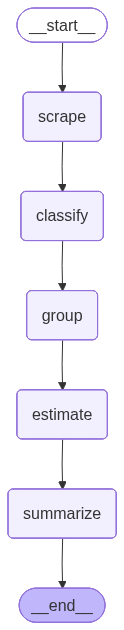

In [ ]:
# Build graph and show structure
graph = build_renovation_graph(settings)

try:
    # Try to display as mermaid if available
    from IPython.display import Image, display
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # Fallback to ASCII
    print("Graph structure:")
    print("""\nSCRAPE → CLASSIFY → GROUP → ESTIMATE → SUMMARIZE → END\n""")
    print("Each node receives state and settings as parameters.")

In [2]:
# Setup - Add backend to path and load environment
import sys
from pathlib import Path

backend_dir = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
if str(backend_dir) not in sys.path:
    sys.path.insert(0, str(backend_dir))

from dotenv import load_dotenv
load_dotenv(backend_dir / ".env")

# Force reload of modules to pick up changes
import importlib
if 'app.services.image_classifier' in sys.modules:
    importlib.reload(sys.modules['app.services.image_classifier'])
if 'app.services.renovation_estimator' in sys.modules:
    importlib.reload(sys.modules['app.services.renovation_estimator'])
if 'app.prompts.renovation' in sys.modules:
    importlib.reload(sys.modules['app.prompts.renovation'])

print("✅ Modules reloaded with latest changes")

✅ Modules reloaded with latest changes


In [3]:
# Test the full pipeline with the problematic property
from app.config import Settings
from app.graphs.main_graph import scrape_node, classify_node, group_node, estimate_node
from app.graphs.state import create_initial_state

settings = Settings()
IDEALISTA_URL = "https://www.idealista.pt/imovel/34675004/"

print(f"Testing with URL: {IDEALISTA_URL}")
print(f"Classification model: {settings.openai_classification_model}")
print(f"Estimation model: {settings.openai_vision_model}")

# Step 1: Scrape
initial_state = create_initial_state(IDEALISTA_URL, user_id="notebook_test")
state_after_scrape = await scrape_node(initial_state, settings=settings)

num_images = len(state_after_scrape["property_data"].image_urls)
print(f"\n✅ Scrape: Found {num_images} images")

# Step 2: Classify
state_after_classify = await classify_node(state_after_scrape, settings=settings)
classifications = state_after_classify["classifications"]

# Check for errors (confidence=0 indicates fallback was used)
errors = [c for c in classifications if c.confidence == 0.0]
zeros = [c for c in classifications if c.room_number == 0]

print(f"✅ Classify: {len(classifications)} images classified")
print(f"   - Errors (confidence=0): {len(errors)}")
print(f"   - Zero room_numbers: {len(zeros)}")

if errors:
    print(f"   ⚠️  WARNING: {len(errors)} classifications failed and used fallback")
    for c in errors:
        print(f"      - {c.image_url[-40:]}")

if zeros:
    print(f"   ⚠️  WARNING: {len(zeros)} classifications have room_number=0")
    for c in zeros:
        print(f"      - {c.room_type.value} #0: {c.image_url[-40:]}")


/Users/armindomatias/code/armindomatias/personal/housing_agent/backend/.venv/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


Testing with URL: https://www.idealista.pt/imovel/34675004/
Classification model: gpt-4o-mini
Estimation model: gpt-4o

✅ Scrape: Found 21 images
✅ Classify: 21 images classified
   - Errors (confidence=0): 0
   - Zero room_numbers: 0


In [4]:
# Step 3: Group
state_after_group = await group_node(state_after_classify, settings=settings)
grouped = state_after_group["grouped_images"]

print(f"✅ Group: {len(grouped)} rooms identified")
for room_key, images in grouped.items():
    print(f"   - {room_key}: {len(images)} image(s)")

# Step 4: Estimate (this should now work with increased token limit)
print("\n🔍 Testing estimation with increased token limit (2000 tokens)...")
state_after_estimate = await estimate_node(state_after_group, settings=settings)

# Check results
current_step = state_after_estimate.get("current_step")
error = state_after_estimate.get("error")
room_analyses = state_after_estimate.get("room_analyses", [])

print(f"\n✅ Estimate: current_step='{current_step}'")
if error:
    print(f"   ❌ ERROR: {error}")
else:
    print(f"   ✅ No errors")
    
print(f"   - Room analyses generated: {len(room_analyses)}")

if room_analyses:
    total_min = sum(a.cost_min for a in room_analyses)
    total_max = sum(a.cost_max for a in room_analyses)
    print(f"   - Total cost range: {total_min:,.0f}€ - {total_max:,.0f}€")
    
    print("\n   Room breakdown:")
    for analysis in room_analyses:
        print(f"      • {analysis.room_label}: {analysis.condition.value} | {analysis.cost_min:,.0f}€ - {analysis.cost_max:,.0f}€ | {len(analysis.renovation_items)} items")


Estimation failed: '\n    "condition"'


✅ Group: 5 rooms identified
   - corredor_1: 2 image(s)
   - sala_1: 4 image(s)
   - cozinha_1: 5 image(s)
   - quarto_1: 5 image(s)
   - casa_de_banho_1: 2 image(s)

🔍 Testing estimation with increased token limit (2000 tokens)...

✅ Estimate: current_step='error'
   ❌ ERROR: '\n    "condition"'
   - Room analyses generated: 0


In [5]:
# Check if the module has the updated token limit
from app.services.renovation_estimator import RenovationEstimatorService
import inspect

# Get the source of the analyze_room method to verify token limit
source = inspect.getsource(RenovationEstimatorService.analyze_room)

# Find the max_tokens line
for line in source.split('\n'):
    if 'max_tokens' in line:
        print(f"Found: {line.strip()}")
        break


Found: max_tokens=2000,  # Increased for detailed room analysis JSON


In [6]:
# Test a single room analysis with debugging
from app.services.renovation_estimator import RenovationEstimatorService
from app.models.property import RoomType
import json

estimator = RenovationEstimatorService(
    openai_api_key=settings.openai_api_key,
    model=settings.openai_vision_model
)

# Get the first room from grouped images
first_room_key = list(grouped.keys())[0]
first_room_images = grouped[first_room_key]

# Extract room info
sample_classification = first_room_images[0]
room_type = sample_classification.room_type if hasattr(sample_classification, 'room_type') else RoomType(sample_classification['room_type'])
room_number = sample_classification.room_number if hasattr(sample_classification, 'room_number') else sample_classification['room_number']
image_urls = [img.image_url if hasattr(img, 'image_url') else img['image_url'] for img in first_room_images]

print(f"Testing room: {room_type.value} #{room_number}")
print(f"Number of images: {len(image_urls)}")

try:
    # Analyze the room
    analysis = await estimator.analyze_room(room_type, room_number, image_urls)
    
    print(f"\n✅ Analysis successful!")
    print(f"   Condition: {analysis.condition.value}")
    print(f"   Cost range: {analysis.cost_min:,.0f}€ - {analysis.cost_max:,.0f}€")
    print(f"   Items: {len(analysis.renovation_items)}")
    print(f"   Confidence: {analysis.confidence:.2f}")
    
except Exception as e:
    print(f"\n❌ Analysis failed: {e}")
    print(f"   Error type: {type(e).__name__}")


Testing room: corredor #1
Number of images: 2

❌ Analysis failed: '\n    "condition"'
   Error type: KeyError


In [7]:
# Let's manually call the OpenAI API to see the raw response
from openai import AsyncOpenAI
from app.prompts.renovation import ROOM_ANALYSIS_PROMPT
from app.services.image_classifier import ImageClassifierService

classifier = ImageClassifierService(settings.openai_api_key)
room_label = classifier.get_room_label(room_type, room_number)

# Build the prompt
prompt = ROOM_ANALYSIS_PROMPT.format(
    room_label=room_label,
    num_images=len(image_urls),
)

# Build message content
content = [{"type": "text", "text": prompt}]
for url in image_urls[:4]:
    content.append({
        "type": "image_url",
        "image_url": {"url": url, "detail": "high"},
    })

# Make API call
client = AsyncOpenAI(api_key=settings.openai_api_key)

print(f"Calling OpenAI API for {room_label}...")
print(f"Model: {settings.openai_vision_model}")
print(f"Max tokens: 2000")

response = await client.chat.completions.create(
    model=settings.openai_vision_model,
    messages=[{"role": "user", "content": content}],
    max_tokens=2000,
    response_format={"type": "json_object"},
)

raw_content = response.choices[0].message.content
print(f"\n✅ API call successful")
print(f"Response length: {len(raw_content)} characters")
print(f"Finish reason: {response.choices[0].finish_reason}")

# Try to parse the JSON
try:
    data = json.loads(raw_content)
    print(f"\n✅ JSON parsed successfully")
    print(f"Keys in response: {list(data.keys())}")
    
    # Check if required fields exist
    required_fields = ["condition", "condition_notes", "renovation_items", "cost_min", "cost_max", "confidence", "reasoning"]
    for field in required_fields:
        if field in data:
            print(f"   ✓ {field}: present")
        else:
            print(f"   ✗ {field}: MISSING")
            
except json.JSONDecodeError as e:
    print(f"\n❌ JSON parsing failed: {e}")
    print(f"\nFirst 500 characters of response:")
    print(raw_content[:500])
    print(f"\nLast 200 characters of response:")
    print(raw_content[-200:])


KeyError: '\n    "condition"'